In [2]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from src.data_quality_checks import check_missing_data
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap

c:\Users\Firew Ayele\Desktop\kifiya\AlphaCare-_nsurance_Solutions\.venv_insurance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

Load and prepare the data

In [3]:
df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|', low_memory=False)

# df = pd.read_csv('../data/cleaned_data.csv', header=None,low_memory=False)

In [4]:
# selecting relevant columns
relevant_cols = ['TotalPremium', 'TotalClaims', 'Gender', 'PostalCode', 'Province', 'VehicleType', 'RegistrationYear', 'NewVehicle']

df_relevant_cols = df[relevant_cols]

In [5]:
# checking for columns with missing values
missing_data = check_missing_data(df_relevant_cols)
print(missing_data)

   Column Name  Missing Values  Percentage Missing
2       Gender            9536            0.953507
5  VehicleType             552            0.055195
7   NewVehicle          153295           15.327998


In [6]:
# data cleaning
df_relevant_cols.loc[:, 'VehicleType'] = df_relevant_cols['VehicleType'].fillna(df_relevant_cols['VehicleType'].mode()[0])
df_relevant_cols.loc[:, 'NewVehicle'] = df_relevant_cols['NewVehicle'].fillna(df_relevant_cols['NewVehicle'].mode()[0])
df_relevant_cols.loc[:, 'Gender'] = df_relevant_cols['Gender'].fillna(df_relevant_cols['Gender'].mode()[0])

In [7]:
# checking for columns with missing values
missing_data = check_missing_data(df_relevant_cols)
print(missing_data)

Success: No missing values.


In [8]:
df_relevant_cols.head(10)

,TotalPremium,TotalClaims,Gender,PostalCode,Province,VehicleType,RegistrationYear,NewVehicle
0,21.929825,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
1,21.929825,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
2,0.000000,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
3,512.848070,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
4,0.000000,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
5,3.256435,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
6,50.474737,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
7,35.332316,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
8,0.000000,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months
9,1.009474,0.0,Not specified,1459,Gauteng,Passenger Vehicle,2004,More than 6 months


Encoding categorical data

In [9]:

categorical_features = ['Province', 'PostalCode', 'Gender', 'VehicleType', 'RegistrationYear', 'NewVehicle']
encoder = LabelEncoder()

for feature in categorical_features:
    df_relevant_cols[feature] = encoder.fit_transform(df_relevant_cols[feature])

C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_12876\1617156014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant_cols[feature] = encoder.fit_transform(df_relevant_cols[feature])
C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_12876\1617156014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant_cols[feature] = encoder.fit_transform(df_relevant_cols[feature])
C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_12876\1617156014.py:5: SettingWithCopyWarning: 
A value is trying to b

In [10]:
df_relevant_cols.head(10)

,TotalPremium,TotalClaims,Gender,PostalCode,Province,VehicleType,RegistrationYear,NewVehicle
0,21.929825,0.0,2,261,2,4,13,1
1,21.929825,0.0,2,261,2,4,13,1
2,0.000000,0.0,2,261,2,4,13,1
3,512.848070,0.0,2,261,2,4,13,1
4,0.000000,0.0,2,261,2,4,13,1
5,3.256435,0.0,2,261,2,4,13,1
6,50.474737,0.0,2,261,2,4,13,1
7,35.332316,0.0,2,261,2,4,13,1
8,0.000000,0.0,2,261,2,4,13,1
9,1.009474,0.0,2,261,2,4,13,1


Split data into features and target variable

In [11]:

X = df_relevant_cols.drop(['TotalClaims', 'TotalPremium'], axis=1)
y = df_relevant_cols['TotalClaims']  # we are predicting TotalClaims


In [12]:
df_relevant_cols['ClaimRatio'] = df_relevant_cols['TotalClaims'] / df_relevant_cols['TotalPremium']


C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_12876\2236652744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant_cols['ClaimRatio'] = df_relevant_cols['TotalClaims'] / df_relevant_cols['TotalPremium']


In [13]:
print(df_relevant_cols['ClaimRatio'])

0          0.0
1          0.0
2          NaN
3          0.0
4          NaN
          ... 
1000093    0.0
1000094    0.0
1000095    0.0
1000096    0.0
1000097    0.0
Name: ClaimRatio, Length: 1000098, dtype: float64


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Build Models

Linear Regression

In [15]:
# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

Decision Tree

In [16]:
# Initialize and train the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

In [17]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [18]:
from xgboost import XGBRegressor
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

Model Evaluation

In [19]:
# Function to evaluate models
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

In [44]:
# Evaluate each model
metrics_lr = evaluate_model(y_test, y_pred_lr)
metrics_dt = evaluate_model(y_test, y_pred_dt)
metrics_rf = evaluate_model(y_test, y_pred_rf)
metrics_xg = evaluate_model(y_test, y_pred_xgb)

print(f'Linear Regression:\n  - MAE={metrics_lr[0]}\n  - MSE={metrics_lr[1]}\n  - RMSE={metrics_lr[2]}\n  - R²={metrics_lr[3]}')
print(f'Decision Tree:\n  - MAE={metrics_dt[0]}\n  - MSE={metrics_dt[1]}\n  - RMSE={metrics_dt[2]}\n  - R²={metrics_dt[3]}')
print(f'Random Forest:\n  - MAE={metrics_rf[0]}\n  - MSE={metrics_rf[1]}\n  - RMSE={metrics_rf[2]},\n  - R²={metrics_rf[3]}')
print(f'XGBoost:\n  - MAE={metrics_xg[0]}\n  - MSE={metrics_xg[1]}\n  - RMSE={metrics_xg[2]},\n  - R²={metrics_xg[3]}')


Linear Regression:
  - MAE=129.7813507781326
  - MSE=4886080.188676738
  - RMSE=2210.447961087693
  - R²=6.280666758573528e-05
Decision Tree:
  - MAE=129.06420618037762
  - MSE=4907972.824057604
  - RMSE=2215.3945075443344
  - R²=-0.004417525118234122
Random Forest:
  - MAE=128.6475483446711
  - MSE=4908052.174972609
  - RMSE=2215.412416452659,
  - R²=-0.00443376429732556
XGBoost:
  - MAE=130.3418512825158
  - MSE=4895007.532015039
  - RMSE=2212.4663911605617,
  - R²=-0.0017641757594122343


Feature Importance Analysis

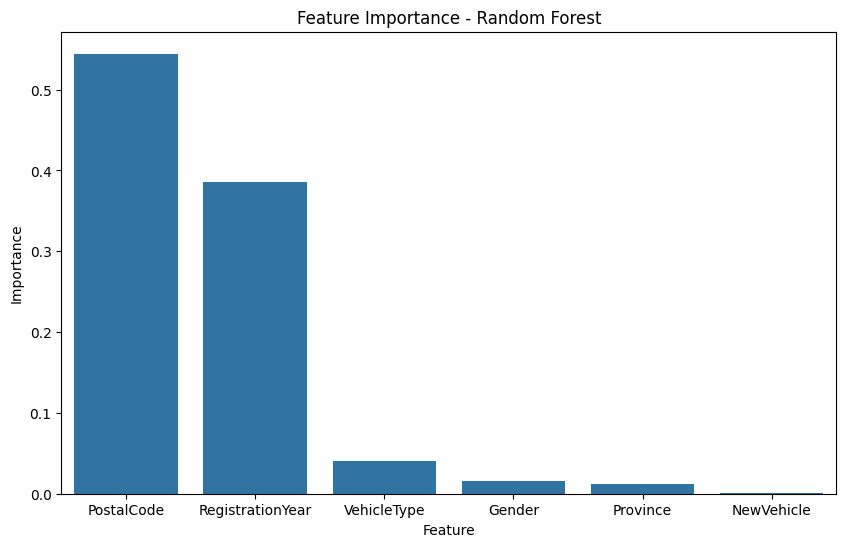

In [76]:
# Feature importance for Random Forest
importances_rf = rf_model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_rf})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()

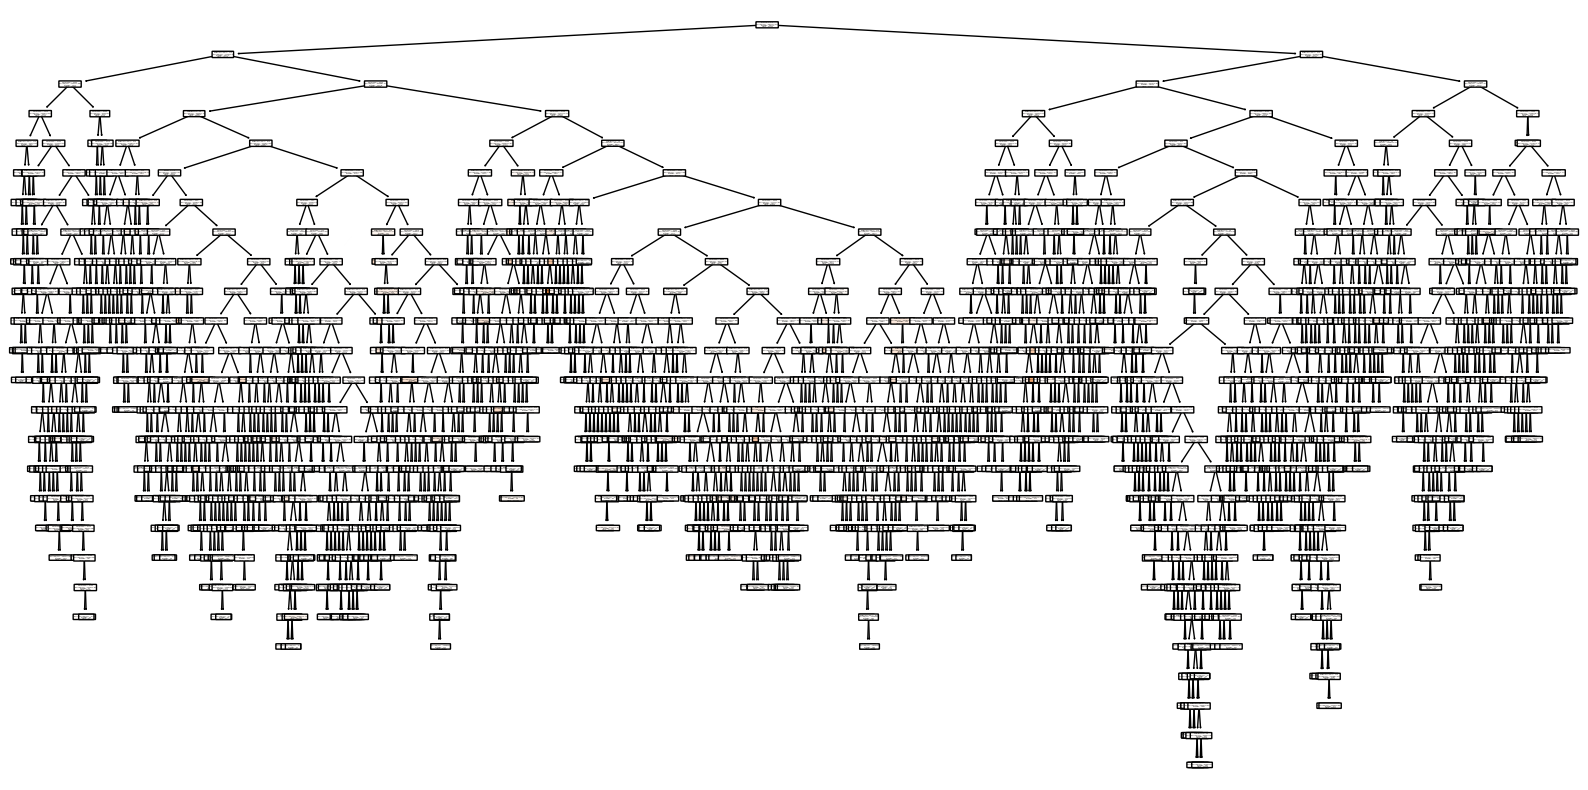

In [60]:
# Random Forest tree
from sklearn.tree import plot_tree
tree_index = 0
single_tree = rf_model.estimators_[tree_index]
plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

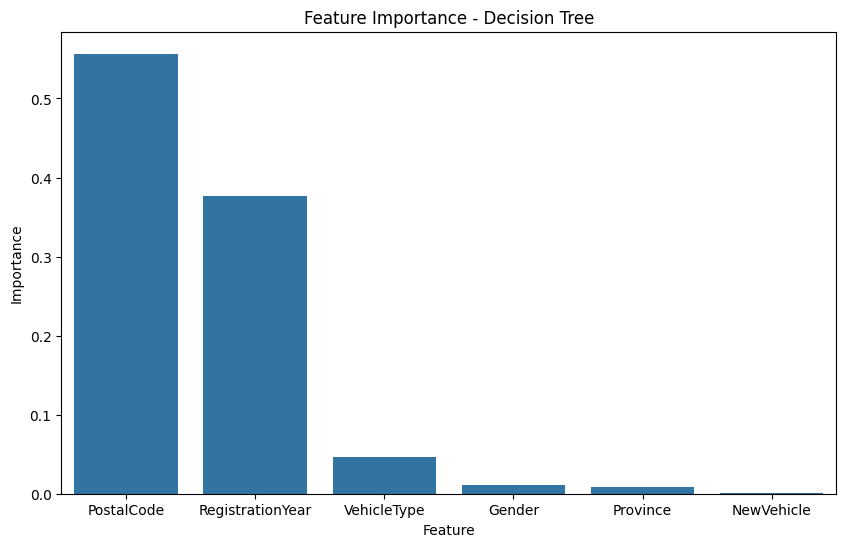

In [77]:
# Feature importance for Decision Tree
importances_rf = dt_model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_rf})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.title('Feature Importance - Decision Tree')
plt.show()

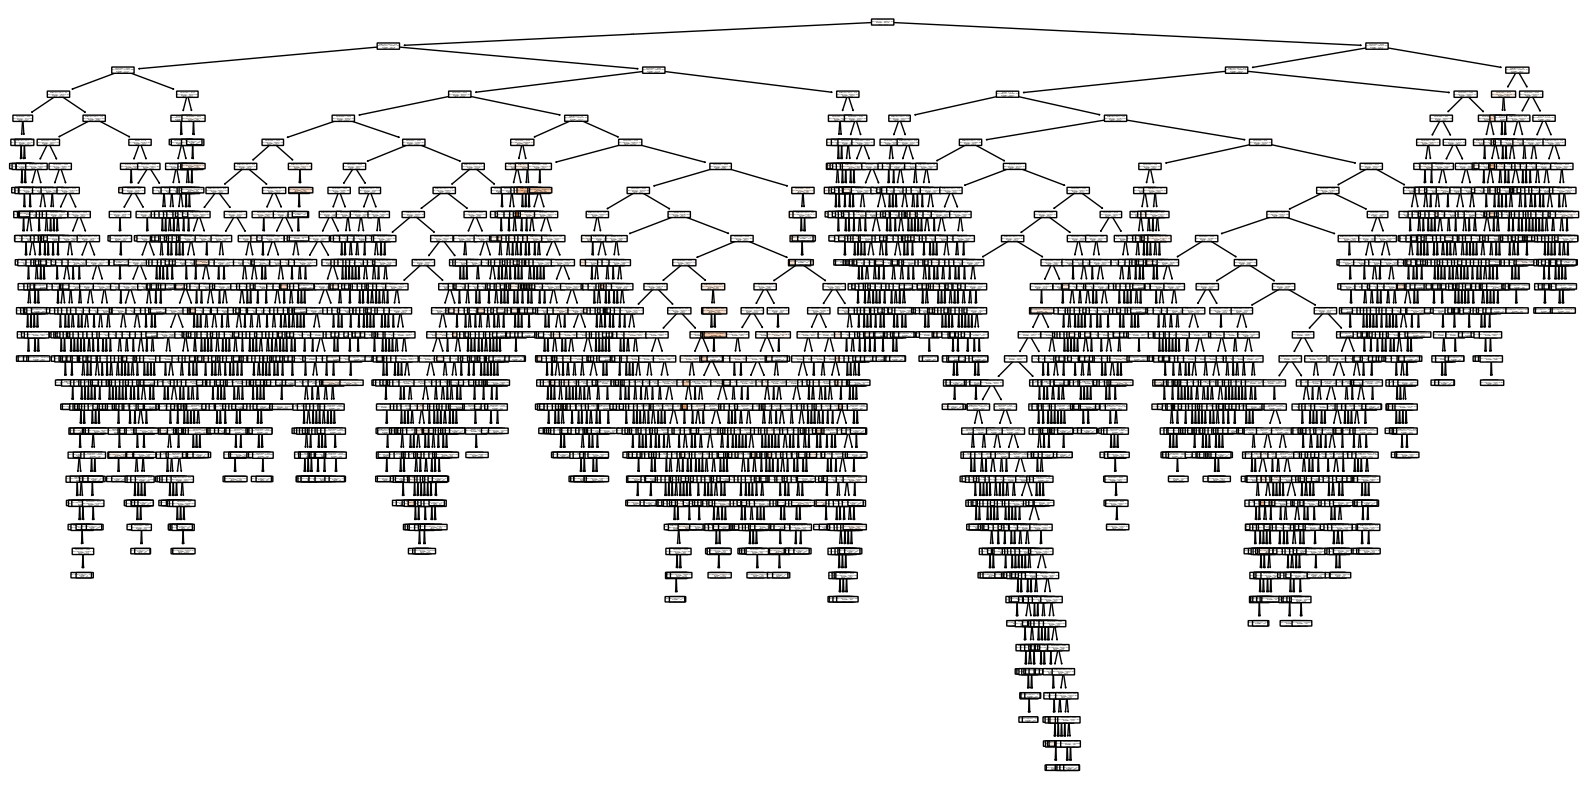

In [62]:
# Feature importance for Decision Tree
from sklearn.tree import plot_tree
tree_index = 0
plt.figure(figsize=(20, 10))
plot_tree(decision_tree=dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

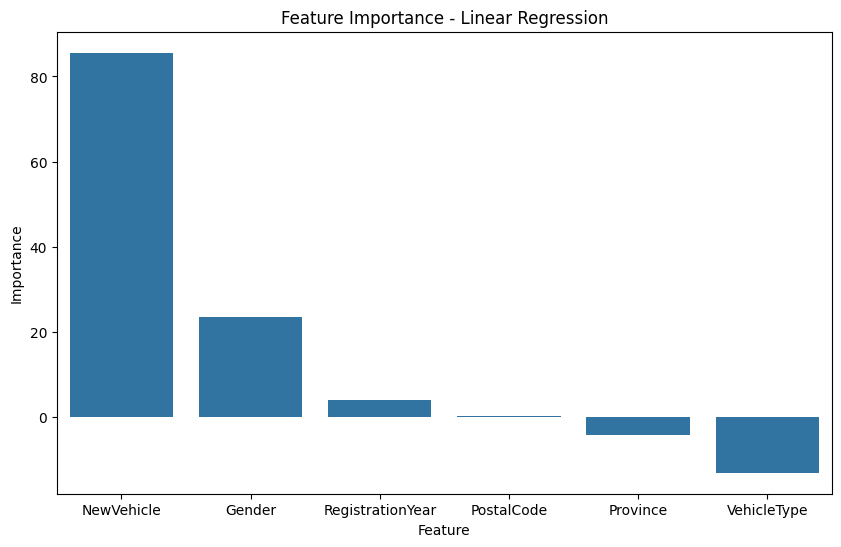

In [74]:
# Feature importance for Linear Regression
importances_rf = lr_model.coef_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_rf})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.title('Feature Importance - Linear Regression')
plt.show()

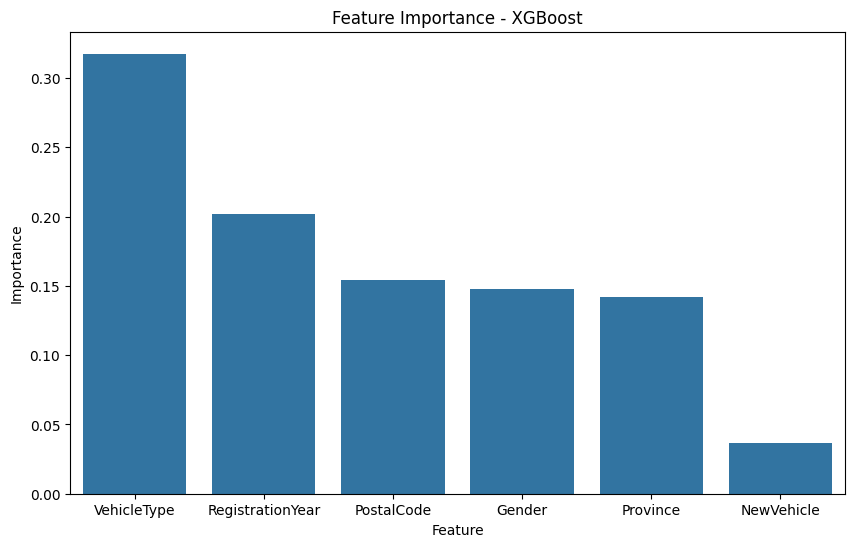

In [75]:
# Feature Importance - XGBoost
importances_xgb = xgb_model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_xgb})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.title('Feature Importance - XGBoost')
plt.show()